In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import tensorflow_hub as hub
import keras

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.10.0


In [2]:
# Lets build a dictionary to mantain our char labels in memory. 
LABEL_STR = {0.0: 'A', 1.0: 'C', 2.0: 'F', 3.0: 'H', 4.0: 'J',
             5.0: 'M', 6.0: 'P', 7.0: 'S', 8.0: 'T', 9.0: 'Y'}

In [3]:
# Loading z-normalized dataset
dataset = np.load('char_dataset.npz')
X = dataset['x']
Y = dataset['y']
print(X.shape)
print(Y.shape)

(230, 14, 1280)
(230,)


In [4]:
# Sampling data into 250ms duration with 64ms sliding increment
X_new = np.zeros((36110,32,14))
Y_new = np.zeros((36110,))
npt = 32
stride = 8
ctr = 0
for i in range(0,230):
    y = Y[i]
    a= X[i,:,:]
    a = a.transpose()
    val = 0
    while val<=(len(a)-npt):
        x = a[val:val+npt,:]
        X_new[ctr,:,:] = x
        Y_new[ctr] = y
        val = val+stride
        ctr = ctr+1

In [5]:
# Creating Datasets

from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=SEED)
y_train = to_categorical(y_train, num_classes=10, dtype='int')
y_test = to_categorical(y_test, num_classes=10, dtype='int')

print(f'''
X_train shape:{X_train.shape} -> Train Labels Shape: {y_train.shape}
X_test shape:{X_test.shape} -> Test Labels Shape: {y_test.shape}''')


X_train shape:(28888, 32, 14) -> Train Labels Shape: (28888, 10)
X_test shape:(7222, 32, 14) -> Test Labels Shape: (7222, 10)


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
# Building VIT transformer with Transfer-Learn approach
## Based on: https://colab.research.google.com/github/sayakpaul/ViT-jax2tf/blob/main/fine_tune.ipynb#scrollTo=yZ0gsA41RVVM

def get_model(
    handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1", 
    num_classes=10,
):
    hub_layer = hub.KerasLayer(handle, trainable=True, name = 'vit_s16_fe')

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_s16_fe (KerasLayer)     (None, 384)               21665664  
                                                                 
 dense (Dense)               (None, 10)                3850      
                                                                 
Total params: 21,669,514
Trainable params: 21,669,514
Non-trainable params: 0
_________________________________________________________________


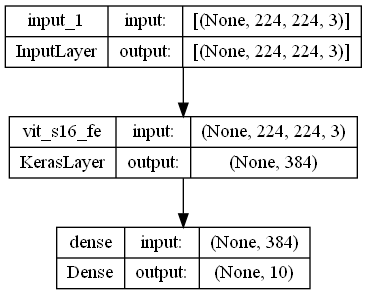

In [8]:
tf.keras.utils.plot_model(model, to_file = 'VIT_model.png', show_shapes=True)

In [9]:
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
num_train = tf.data.experimental.cardinality(train_dataset)
num_test = tf.data.experimental.cardinality(test_dataset)

In [10]:
# Learning rate scheduling (warm-up + [cosine | linear])
## Reference: https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [11]:
EPOCHS = 8
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

7222


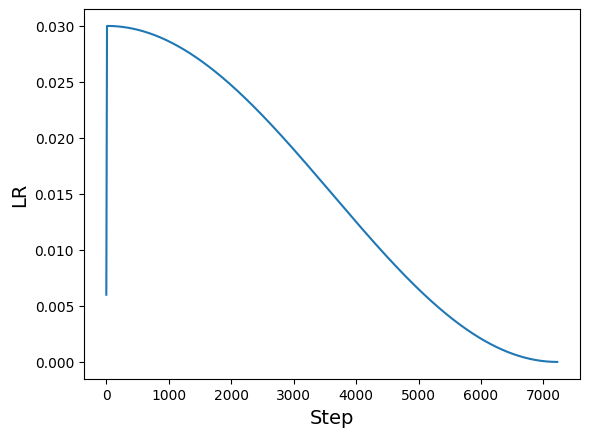

In [12]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [13]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss = keras.losses.CategoricalCrossentropy()

In [14]:
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)

Epoch 1/8


ValueError: in user code:

    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 14)


In [ ]:
plt.figure(figsize=(7, 7))
history = history.history

plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["accuracy"], label="train_accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()